# Collaborative filtering on Google Analytics data

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

In [1]:
import os
PROJECT = "qwiklabs-gcp-03-2787a45a1534" # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-03-2787a45a1534" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.5


## Create raw dataset
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, we combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
"""

df = bq.query(sql).to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,1031539128969021923-1,299918857,46074
1,1655026264169370690-165,299170525,28438
2,1777072527276763113-113,299827911,6698
3,1818199630884742957-45,299936493,42307
4,2211768598185554204-465,255478055,155887


In [5]:
stats = df.describe()
stats

,session_duration
count,2.843020e+05
mean,1.247962e+05
std,2.311864e+05
min,1.000000e+00
25%,1.607700e+04
50%,5.626050e+04
75%,1.271750e+05
max,7.690598e+06


<AxesSubplot:ylabel='Frequency'>

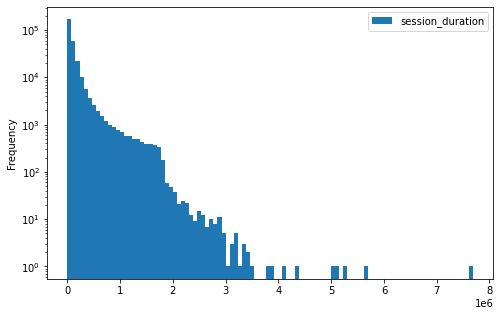

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

<AxesSubplot:ylabel='Frequency'>

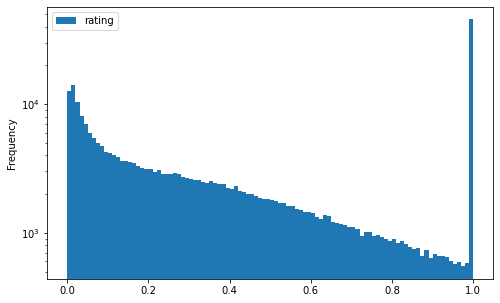

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [10]:
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)

In [11]:
!head data/collab_raw.csv

1031539128969021923-1,299918857,0.24568213933399097
1655026264169370690-165,299170525,0.15164102700829177
1777072527276763113-113,299827911,0.03571599968005972
1818199630884742957-45,299936493,0.22559522222518463
2211768598185554204-465,255478055,0.831242168128616
2695873766870665370-5,299587923,0.20680406324152825
284119518435695096-1,299930675,1.0
2869452701170253857-741,299693260,0.04747913722771749
3010380941869544318-1441,299133651,0.027877462873596926
3074506062059024768-18,299945076,0.19248673580931558


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so we need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> We will need to save the above mapping to a file because at prediction time, we'll need to know how to map the contentId in the table above to the itemId.
<li> We'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
1031539128969021923-1,299918857,0.2456821393339909
1655026264169370690-165,299170525,0.1516410270082917
1777072527276763113-113,299827911,0.0357159996800597

==> data/items.csv <==
299918857,0
299170525,1
299827911,2

==> data/users.csv <==
1031539128969021923-1,0
1655026264169370690-165,1
1777072527276763113-113,2


In [14]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [15]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.245682
1,1,1,0.151641
2,2,2,0.035716
3,3,3,0.225595
4,4,4,0.831242


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.245682
1,1,1,0.151641
2,2,2,0.035716
3,3,3,0.225595
4,4,4,0.831242


In [17]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5670 items, 120869 users, 284302 interactions


In [18]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

0 [    0   362   588 ... 11687 58106 14393] [0.25 1.   0.3  ... 0.2  0.6  0.36]
1 [    1    30   249   351   800  1096  1285  1464  1472  1475  1750  1753
  1959  2014  2018  2162  2229  2261  2274  2379  2467  2479  2522  2543
  2699  2702  3255  3315  3393  3934  4134  4316  4621  4738  1963  5187
  5431  5433  2299  5537  5548  5676  5780  5985  6132  6277  6386  6610
  7075  7439  7508  7610  7631  7742  7749  7785  7827  8028  2009  8253
  8311  8430  8435  8481  8563  8670  8710  8881  9063  9123  9521 10014
 10069  1142 10569  7794 10783 11098 11216 11246  8547 11535 11629 11833
 12099 12120 12199 12242 12473 12500 12522 12911 13119 13304  5034 13447
 13738 13915 14251 14608 14609 14697 14709 15057 15200 15530 15531 15712
 15823 15863 10753 15947 16076 16322 16505 16593  8923 16839 16934 17140
 17214   492 17657 17779 17784 17811 17904  7870 18429 18510 18749 18755
 18774 18908 19057 19193 19200 11721  9042  3042 19285 19300 19409 19494
 19683 12394 19732 19814 19830 19843 19877

In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
!ls -lrt data

total 36552
-rw-r--r-- 1 jupyter jupyter 14121616 Nov  8 15:03 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  3525697 Nov  8 15:03 users.csv
-rw-r--r-- 1 jupyter jupyter    82217 Nov  8 15:03 items.csv
-rw-r--r-- 1 jupyter jupyter  7661290 Nov  8 15:03 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2296744 Nov  8 15:03 users_for_item
-rw-r--r-- 1 jupyter jupyter  9728585 Nov  8 15:03 items_for_user


To summarize, we created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.

In [24]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        features = {
            "key": tf.FixedLenFeature(shape = [1], dtype = tf.int64),
            "indices": tf.VarLenFeature(dtype = tf.int64),
            "values": tf.VarLenFeature(dtype = tf.float32)}
        parsed_features = tf.parse_single_example(serialized = protos, features = features)
        values = tf.sparse_merge(sp_ids = parsed_features["indices"], sp_values = parsed_features["values"], vocab_size = vocab_size)
        # Save key to remap after batching
        # This is a temporary workaround to assign correct row numbers in each batch.
        # You can ignore details of this part and remap_keys().
        key = parsed_features["key"]
        decoded_sparse_tensor = tf.SparseTensor(indices = tf.concat(values = [values.indices, [key]], axis = 0), 
                                                values = tf.concat(values = [values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return decoded_sparse_tensor
  
  
    def remap_keys(sparse_tensor):
        # Current indices of our SparseTensor that we need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of our SparseTensor that we need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [25]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

SparseTensorValue(indices=array([[   0,    0],
       [   0,   95],
       [   0, 5626],
       [   0, 5632],
       [   0, 5644],
       [   0, 5647],
       [   0, 5653],
       [   1,    1],
       [   1,  100],
       [   1,  144],
       [   1,  978],
       [   1, 5635],
       [   2,    2],
       [   2,   32],
       [   2,  893],
       [   2, 1614],
       [   2, 2649],
       [   2, 5630],
       [   2, 5632],
       [   3,    3],
       [   3,   58],
       [   3, 5664],
       [   3, 5669]]), values=array([0.25, 0.36, 0.04, 1.  , 0.07, 0.32, 0.03, 0.15, 0.06, 0.48, 0.13,
       0.83, 0.04, 0.03, 0.05, 0.02, 0.02, 0.02, 0.13, 0.23, 0.28, 0.13,
       0.76], dtype=float32), dense_shape=array([   4, 5670]))
SparseTensorValue(indices=array([[   4,    4],
       [   4,  136],
       [   4,  168],
       [   4,  469],
       [   4, 5620],
       [   4, 5629],
       [   4, 5650],
       [   4, 5656],
       [   5,    5],
       [   5,   91],
       [   5,  178],
       [   5, 56

In [26]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, we have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [27]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 12 steps, evaluating once every 236 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fef980e4a90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local

In [28]:
!ls wals_trained

batch_pred.txt
checkpoint
eval
events.out.tfevents.1636383923.tensorflow-1-15-20211108-104507
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-12.data-00000-of-00001
model.ckpt-12.index
model.ckpt-12.meta


In [29]:
!head wals_trained/batch_pred.txt

632,1458,3023
3785,4847,1061
2838,5179,3959
3378,1412,447
4065,1948,1882
1038,5581,5447
2764,2005,4180
574,5607,725
3023,3225,388
2246,3364,574


## Run as a Python module

Let's run it as Python module for just a few steps.

In [30]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [31]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ai-platform local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

Will train for 2 steps, evaluating once every 236 steps




Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4d8fbcb910>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'cloud', '_is_chief': True, '_evaluation_master': '', '_train

## Run on Cloud

In [32]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

Copying file://data/collab_mapped.csv [Content-Type=text/csv]...
Copying file://data/collab_raw.csv [Content-Type=text/csv]...
Copying file://data/items.csv [Content-Type=text/csv]...
Copying file://data/users_for_item [Content-Type=application/octet-stream]...
Copying file://data/users.csv [Content-Type=text/csv]...
Copying file://data/items_for_user [Content-Type=application/octet-stream]...
- [6/6 files][ 35.7 MiB/ 35.7 MiB] 100% Done                                    
Operation completed over 6 objects/35.7 MiB.                                     


In [33]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

gs://qwiklabs-gcp-03-2787a45a1534/wals/model_trained us-central1 wals_211108_150600


CommandException: 1 files/objects could not be removed.
ERROR: (gcloud.ai-platform.jobs.submit.training) FAILED_PRECONDITION: Field: job_dir Error: The provided GCS path gs://qwiklabs-gcp-03-2787a45a1534/wals/model_trained cannot be written by service account service-243818477912@cloud-ml.google.com.iam.gserviceaccount.com.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The provided GCS path gs://qwiklabs-gcp-03-2787a45a1534/wals/model_trained
      cannot be written by service account service-243818477912@cloud-ml.google.com.iam.gserviceaccount.com.
    field: job_dir


CalledProcessError: Command 'b'OUTDIR=gs://${BUCKET}/wals/model_trained\nJOBNAME=wals_$(date -u +%y%m%d_%H%M%S)\necho $OUTDIR $REGION $JOBNAME\ngsutil -m rm -rf $OUTDIR\ngcloud ai-platform jobs submit training $JOBNAME \\\n    --region=$REGION \\\n    --module-name=walsmodel.task \\\n    --package-path=${PWD}/walsmodel \\\n    --job-dir=$OUTDIR \\\n    --staging-bucket=gs://$BUCKET \\\n    --scale-tier=BASIC_GPU \\\n    --runtime-version=$TFVERSION \\\n    -- \\\n    --output_dir=$OUTDIR \\\n    --input_path=gs://${BUCKET}/wals/data \\\n    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} \n'' returned non-zero exit status 1.

This took <b>10 minutes</b> for me.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [ ]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [ ]:
args = {
    "output_dir": "gs://{}/wals/model_trained".format(BUCKET),
    "nitems": NITEMS,
    "nusers": NUSERS,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>